In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import shap

In [6]:
# Step 1: Load the Dataset
print("Loading dataset...")
df = pd.read_csv('C:/Users/bhard/OneDrive/Desktop/salesprediction/Advertising.csv')

Loading dataset...


In [4]:
# Step 2: Data Preprocessing
# Checking for missing values
df = df.dropna()

In [5]:
# Feature Engineering
df['TV_Radio'] = df['TV'] * df['Radio']
df['TV_Newspaper'] = df['TV'] * df['Newspaper']
df['Radio_Newspaper'] = df['Radio'] * df['Newspaper']
df['Total_Advertising_Spend'] = df['TV'] + df['Radio'] + df['Newspaper']

In [7]:
# Optional: Adding polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['TV', 'Radio', 'Newspaper']])
poly_feature_names = poly.get_feature_names_out(['TV', 'Radio', 'Newspaper'])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
df = pd.concat([df, df_poly], axis=1)

In [10]:
# Splitting the dataset into features (X) and target (y)
X = df.drop(columns='Sales')
y = df['Sales']

In [9]:
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
# Step 3: Model Selection and Training with Hyperparameter Tuning
# Define the models and hyperparameters
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'alpha': [0.1, 1.0, 10]}),
    'Lasso Regression': (Lasso(max_iter=10000), {'alpha': [0.1, 1.0, 10]}),  # Increased max_iter
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]})
}

best_model = None
best_score = -np.inf

for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    score = grid_search.best_score_
    print(f"{name} Best R2 Score: {score:.4f} with Params: {grid_search.best_params_}")
    if score > best_score:
        best_score = score
        best_model = grid_search.best_estimator_

print(f"\nBest Model: {best_model.__class__.__name__} with R2 Score: {best_score:.4f}")


Linear Regression Best R2 Score: 0.9772 with Params: {}
Ridge Regression Best R2 Score: 0.9772 with Params: {'alpha': 0.1}
Lasso Regression Best R2 Score: 0.9552 with Params: {'alpha': 0.1}
Random Forest Best R2 Score: 0.9839 with Params: {'max_depth': 20, 'n_estimators': 200}
Gradient Boosting Best R2 Score: 0.9873 with Params: {'learning_rate': 0.1, 'n_estimators': 100}

Best Model: GradientBoostingRegressor with R2 Score: 0.9873


In [13]:
# Optional: Stacking Ensemble Model
stacking_model = StackingRegressor(
    estimators=[('ridge', Ridge(alpha=1.0)), ('rf', RandomForestRegressor(n_estimators=100, max_depth=None))],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
)
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('ridge', Ridge()),
                              ('rf', RandomForestRegressor())],
                  final_estimator=GradientBoostingRegressor())

In [14]:
# Step 4: Model Prediction
y_pred = best_model.predict(X_test)
y_pred_stacking = stacking_model.predict(X_test)

In [15]:
# Step 5: Model Evaluation
def evaluate_model(y_test, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Performance on Test Set:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")

evaluate_model(y_test, y_pred, model_name=best_model.__class__.__name__)
evaluate_model(y_test, y_pred_stacking, model_name="Stacking Model")



GradientBoostingRegressor Performance on Test Set:
Mean Absolute Error: 0.3783
Mean Squared Error: 0.2699
Root Mean Squared Error: 0.5195
R-squared: 0.9915

Stacking Model Performance on Test Set:
Mean Absolute Error: 0.4165
Mean Squared Error: 0.3049
Root Mean Squared Error: 0.5521
R-squared: 0.9903


In [16]:
# Step 6: Advanced Visualization
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted Sales')

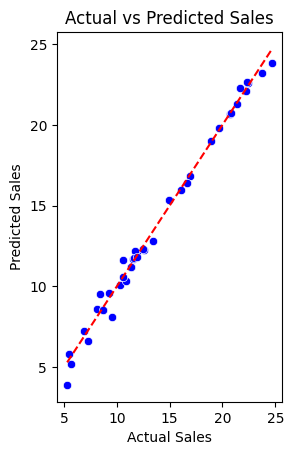

In [17]:
# Scatter plot for Actual vs Predicted Sales
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')

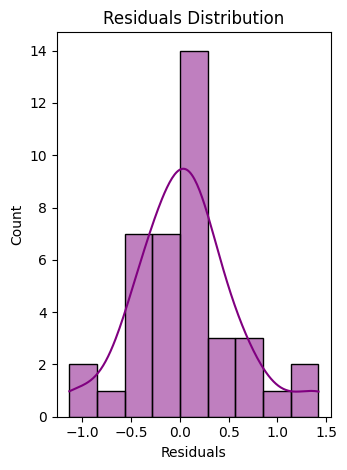

In [18]:
# Residuals Plot
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True, color='purple')
plt.xlabel('Residuals')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

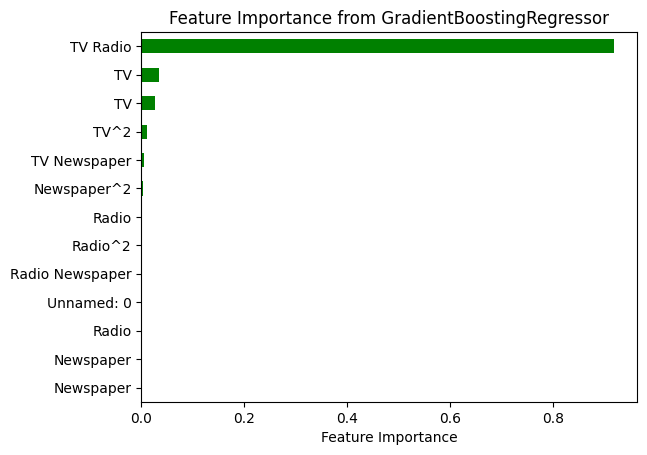

In [19]:
# Feature Importance (for Random Forest or Gradient Boosting)
if isinstance(best_model, (RandomForestRegressor, GradientBoostingRegressor)):
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importances.sort_values().plot(kind='barh', color='green')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance from ' + best_model.__class__.__name__)
    plt.show()


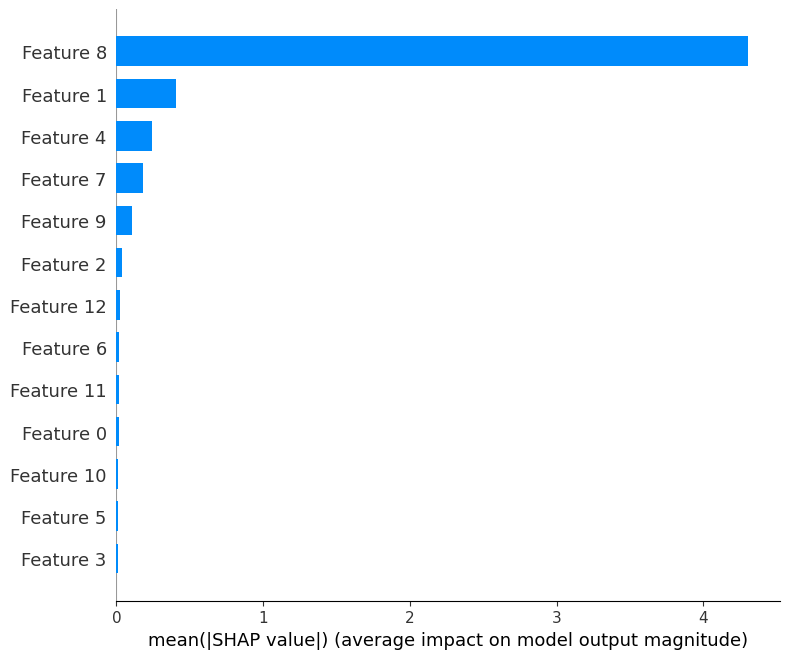

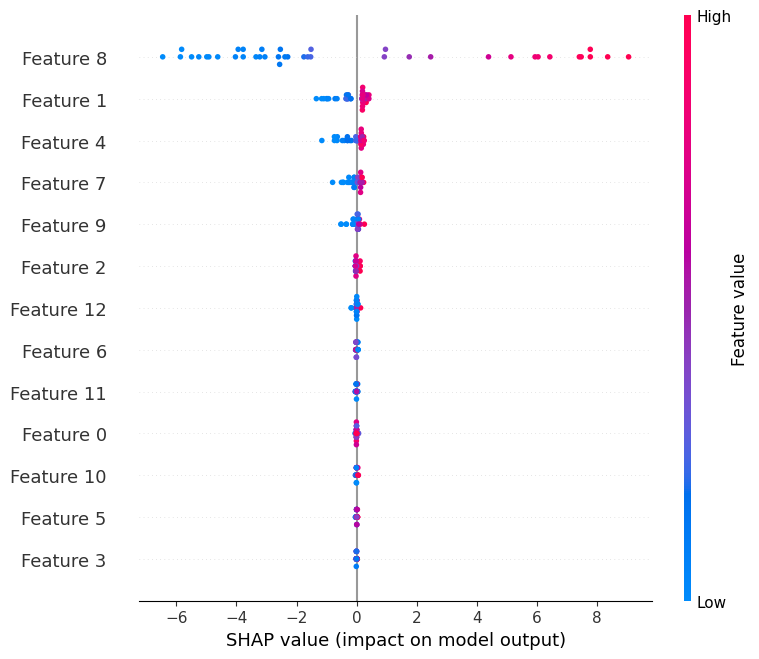

In [20]:
# Step 7: Model Interpretability with SHAP
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)